The selected code is written in Python and it's part of a larger program that uses a plugin-based architecture. The code is using a kernel object to manage plugins and their functions.

First, two variables are defined: plugins_directory and file_path. The plugins_directory variable is set to the string "plugins", which is presumably the directory where the plugins are stored. The file_path variable is set to "data_schema.txt", which is likely a file that contains a data schema.

The read_data_schema_from_file function is then called with file_path as an argument. This function reads the data schema from the specified file and returns it as a string. The returned data schema is stored in the data_schema variable.

Next, there's an if-statement that checks the prompt_rephrase variable. If prompt_rephrase is true, the code imports a plugin named "PromptPlugin" from the plugins directory using the import_plugin_from_prompt_directory method of the kernel object. This method returns a dictionary-like object of functions provided by the plugin. The "PromptRephraser" function from the "PromptPlugin" plugin is then stored in the rephraserFunction variable.

The rephraserFunction is then invoked asynchronously using the invoke method of the kernel object. The invoke method is called with two arguments: the function to be invoked and a KernelArguments object that contains the data schema and a query. The result of the function invocation is stored in the rephrased_prompt variable.

Finally, the code imports another plugin named "DataPlugin" from the plugins directory and stores the "DatabaseDescriptor" function from this plugin in the descriptorFunction variable. This function can presumably be used later in the code to describe a database based on the data schema.

In [46]:
import semantic_kernel as sk
from services import Service
import re
import sqlite3
import pandas as pd
import os

async def PromptToQueryResult(debug=False, prompt_rephrase=False):
    """
    Prompts the user for a query, rephrases the prompt if required, and executes the query using the Semantic Kernel.

    Args:
        debug (bool, optional): If True, prints debug information. Defaults to False.
        prompt_rephrase (bool, optional): If True, rephrases the prompt using a rephraser plugin. Defaults to False.

    Returns:
        DataFrame or any: The result of the executed query, or 'any' if no query is executed.
    """
    kernel = sk.Kernel()
    selectedService = Service.AzureOpenAI
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    
    query = input("Enter your query: ")  # Get query from user
    rephrased_prompt = query
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    if(prompt_rephrase):
        promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "PromptPlugin")
        rephraserFunction = promptFunctions["PromptRephraser"]
        rephrased_prompt_result = await kernel.invoke(rephraserFunction, sk.KernelArguments(data_schema=data_schema, query=query))
        rephrased_prompt = rephrased_prompt_result.data if hasattr(rephrased_prompt_result, 'data') else str(rephrased_prompt_result)

    dataFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    descriptorFunction = dataFunctions["DatabaseDescriptor"]

    
    result = await kernel.invoke(descriptorFunction, sk.KernelArguments(data_schema=data_schema, query= rephrased_prompt))
    result_string = result.data if hasattr(result, 'data') else str(result)
    if(debug):
        print(result_string)
    matches_sql = parse_text_between_tags(result_string,"<sql>", "</sql>")

    if(prompt_rephrase):
        print("User query: " + query)
    print("Rephrased prompt: " + rephrased_prompt)
    if len(matches_sql) > 0:
        sql = matches_sql[0]
        if debug:
            print(sql)
        df = run_sql_query(sql)
    
    

    matches_python = parse_text_between_tags(result_string,"<python>", "</python>")
    if len(matches_python) > 0:
        if debug:
            print(matches_python[0])
        try:
            db_conn = os.getenv("DB_CONNECTION_STRING")
            conn = sqlite3.connect(db_conn)
            exec(matches_python[0])
            conn.close()
        except Exception as e:
            if debug:
                print('hata:' + e)
        except:
            print("An exception occurred")
    if len(matches_sql) > 0:
        df.head()
        return df
    else:  
        return any


def read_data_schema_from_file(file_path):
    """
    Reads the data schema from a file.

    Args:
        file_path (str): The path to the file containing the data schema.

    Returns:
        str: The contents of the file as a string.

    Raises:
        FileNotFoundError: If the file does not exist.

    """
    with open(file_path, 'r') as file:
        data_schema = file.read()
    return data_schema

def parse_text_between_tags(text, start_tag, end_tag):
    """
    Parses the text between the specified start and end tags.

    Args:
        text (str): The text to search within.
        start_tag (str): The start tag to look for.
        end_tag (str): The end tag to look for.

    Returns:
        list: A list of matches found between the start and end tags.
    """
    pattern = rf"{re.escape(start_tag)}(.*?){re.escape(end_tag)}"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def run_sql_query(query):
    """
    Executes the given SQL query and returns the result as a pandas DataFrame.

    Parameters:
    query (str): The SQL query to be executed.

    Returns:
    pandas.DataFrame: The result of the SQL query as a DataFrame.
    """
    db_conn = os.getenv("DB_CONNECTION_STRING")
    conn = sqlite3.connect(db_conn)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df



User query: yıllara göre satış adetleri. histogram. x ekseni yıllar, y ekseni satış adetleri, yığınlar marka.
Rephrased prompt: Generate a histogram showing the number of sales per year, with the x-axis representing the years and the y-axis representing the number of sales. The bars should be stacked by brand.


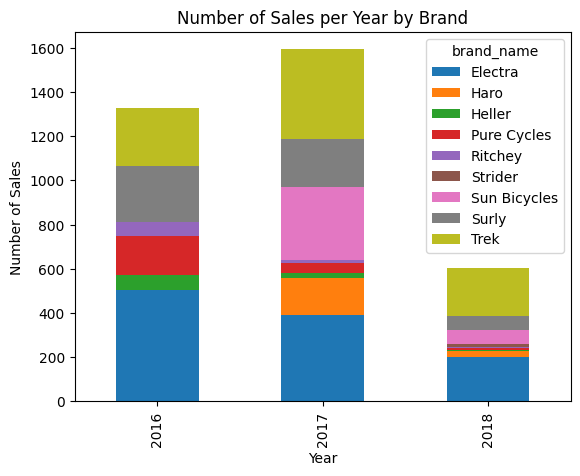

,year,brand_name,sales_count
0,2016,Electra,505
1,2016,Heller,67
2,2016,Pure Cycles,178
3,2016,Ritchey,62
4,2016,Surly,252
5,2016,Trek,263
6,2017,Electra,392
7,2017,Haro,167
8,2017,Heller,23
9,2017,Pure Cycles,46


In [57]:
await PromptToQueryResult(prompt_rephrase=True, debug=False)
